# Algorithme MinMax et Othello

Nous allons implémenté l'algorithme MinMax pour le jeu d'Othello 奥赛罗棋 (aussi appelé Reversi, 黑白棋). Nous travaillerons sur une version simplifiée des règles.

## Règles du jeu

Le jeu se déroule sur un plateau de $n\times m$ cases (le jeu classique est sur un plateau $8\times 8$). Au début, le plateau est vide. Chaque joueur pose à son tour un pion de sa couleur dans une des cases vides du plateau. Lorsque le plateau est rempli, la partie s'arrête. Le joueur qui a le plus de pions de sa couleur sur le plateau gagne.

Les pions peuvent changer de couleur. Si le joueur de couleur rouge pose un pion $p$, alors tous les pions de couleur bleu situés sur une ligne, une colonne ou une diagonale entre $p$ et un autre pion rouge deviennent rouges.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# permet de faire les dessins, le tp ne porte pas sur cette fonction
def tracerPlateau(A):
    n, m = A.shape
    
    plt.xlim(-0.5, n - 0.5)
    plt.ylim(m - 0.5, -0.5)
    
    plt.xticks(np.arange(-0.5, n - 0.5, 1))
    plt.yticks(np.arange(-0.5, m - 0.5, 1))
    plt.tick_params(which = 'major', labelbottom = False, labelleft = False)
    plt.gca().xaxis.tick_top()

    plt.minorticks_on()
    plt.gca().xaxis.set_minor_locator(plt.MultipleLocator(1))
    plt.gca().yaxis.set_minor_locator(plt.MultipleLocator(1))
    plt.gca().xaxis.set_minor_formatter(plt.FormatStrFormatter('%d'))
    plt.gca().yaxis.set_minor_formatter(plt.FormatStrFormatter('%d'))

    plt.tick_params(which = 'minor', top = False, left = False, labeltop = True)

    plt.grid()
    
    N = np.array([[i, j] for i in range(n) for j in range(m) if A[i, j] == 1])
    B = np.array([[i, j] for i in range(n) for j in range(m) if A[i, j] == -1])
    if N.shape[0] > 0:
        plt.scatter(N[:, 1], N[:, 0], marker='o', s = 400, c = 'r')
    if B.shape[0] > 0:
        plt.scatter(B[:, 1], B[:, 0], marker='o', s = 400, c = 'b')

Par exemple, si on est dans la situation suivante

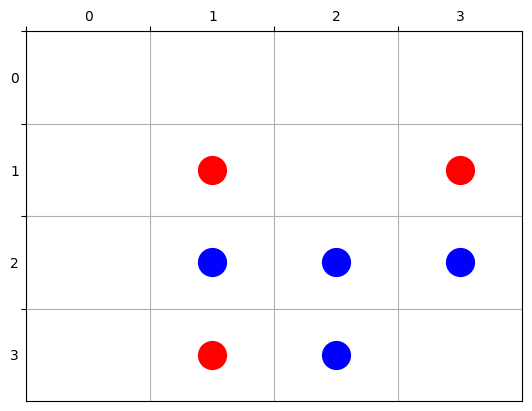

In [3]:
A1 = np.array([[ 0,  0,  0,  0],
               [ 0,  1,  0,  1],
               [ 0, -1, -1, -1],
               [ 0,  1, -1,  0]], int)
tracerPlateau(A1)

et que c'est le tour du joueur rouge, qui place un pion dans la case $(3, 3)$. Alors les pions bleus dans les cases $(3, 2)$, $(2,2)$ et $(2,3)$ deviennent rouges.

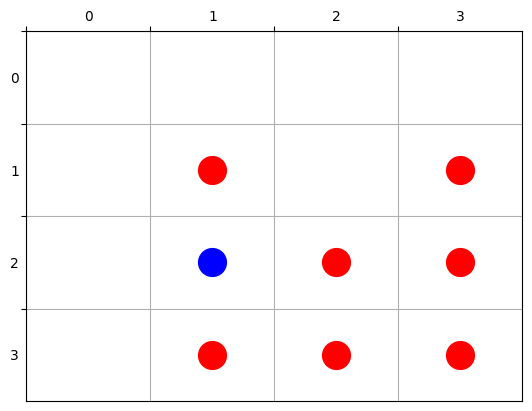

In [4]:
A2 = np.array([[ 0,  0,  0,  0],
               [ 0,  1,  0,  1],
               [ 0, -1,  1,  1],
               [ 0,  1,  1,  1]], int)
tracerPlateau(A2)

Le pion bleu de la case $(2,1)$ ne change pas de couleur, puisqu'il n'est pas entre un pion rouge et le nouveau pion rouge posé en $(3,3)$.

Il faut un pion rouge de l'autre coté du nouveau pion, le bord du plateau ne suffit pas. Dans la position suivante

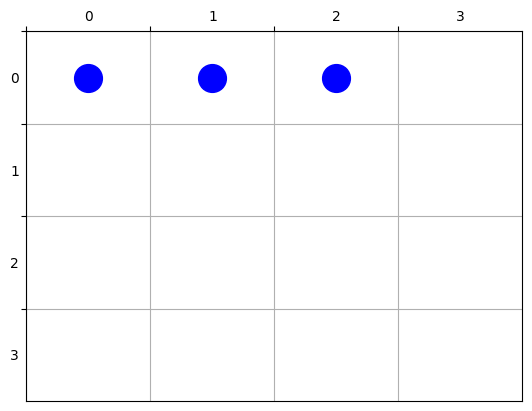

In [5]:
B1 = np.array([[-1, -1, -1,  0],
               [ 0,  0,  0,  0],
               [ 0,  0,  0,  0],
               [ 0,  0,  0,  0]], int)
tracerPlateau(B1)

si le joueur rouge joue en $(1,1)$, les pions ne changent pas de couleur.

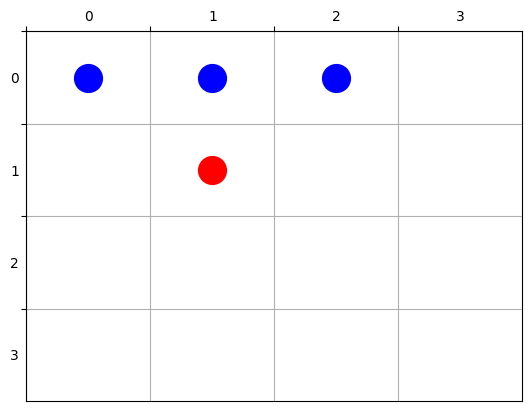

In [6]:
B2 = np.array([[-1, -1, -1,  0],
               [ 0,  1,  0,  0],
               [ 0,  0,  0,  0],
               [ 0,  0,  0,  0]], int)
tracerPlateau(B2)

De plus, en posant un pion rouge, seul les pions bleus jusqu'au *premier* pion rouge changent de couleur. Dans la position suivante

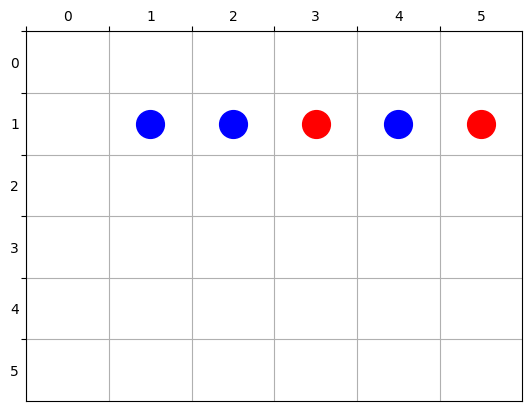

In [7]:
C1 = np.array([[ 0,  0,  0,  0,  0,  0],
               [ 0, -1, -1,  1, -1,  1],
               [ 0,  0,  0,  0,  0,  0],
               [ 0,  0,  0,  0,  0,  0],
               [ 0,  0,  0,  0,  0,  0],
               [ 0,  0,  0,  0,  0,  0]], int)
tracerPlateau(C1)

si rouge joue en $(1,0)$ alors seul les pions $(1,1)$ et $(1,2)$ change de couleur, pas $(1,4)$.

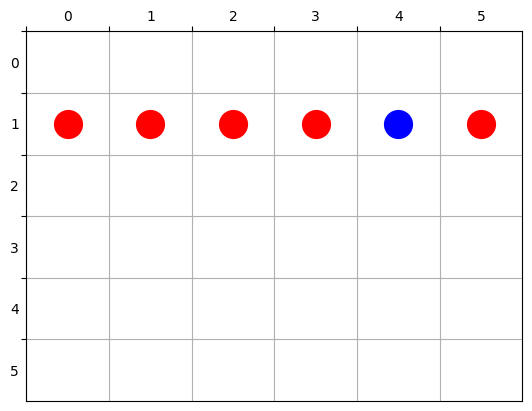

In [8]:
C2 = np.array([[ 0,  0,  0,  0,  0,  0],
               [ 1,  1,  1,  1, -1,  1],
               [ 0,  0,  0,  0,  0,  0],
               [ 0,  0,  0,  0,  0,  0],
               [ 0,  0,  0,  0,  0,  0],
               [ 0,  0,  0,  0,  0,  0]], int)
tracerPlateau(C2)

## Implémentation de MinMax

On pourra écrire l'état du plateau de jeu dans un tableau d'entiers à deux dimensions, où $1$ et $-1$ indiquent les couleurs, et $0$ les cases vides.

### Question 1

Écire une fonction `jouer` qui prend en argument un tableau `A` représentant le plateau, une couleur `c` (de valeur `1` ou `-1`) et les coordonnées `x` et `y` d'une case vide, et qui :
* ajoute un pion de couleur `c` dans la case `(x, y)`,
* change les couleurs des pions sur la ligne, la colonne et les diagonales du nouveau pion si nécessaire,
et qui renvoie le tableau mis à jour.

In [9]:
def jouer(A, c, x, y):
    n, m = A.shape
    A = A.copy()
    
    # les directions nord, sud, est, ouest
    # et les 4 directions diagonales
    l = range(-1, 2)
    directions = [(a, b) for a in l for b in l]
    
    if A[x, y] != 0:
        return None
    
    A[x, y] = c
    
    # on chercher les pions qui doivent changer de couleur
    # dans chaque direction
    tourner = []
    for d in directions:
        a = x + d[0]
        b = y + d[1]
        t1 = [] # la liste des pions rencontrés dans la direction d
        while 0 <= a and a < n and 0 <= b and b < m:
            if A[a, b] == 0:
                break
            if A[a, b] == c:
                # si on a trouvé un pions de la bonne couleur
                # on doit changer la couleur des pions de t1
                tourner = tourner + t1
                break
            t1.append((a, b))
            a += d[0]
            b += d[1]
    
    for u in tourner:
        A[u] *= -1
    
    return A

### Question 2

Proposer un score pertinent pour évaluer une position. L'implémenter dans une fonction `score`.

In [10]:
def score(A):
    return np.sum(A)

### Question 3

Implémenter l'algorithme MinMax. Votre fonction prendra en argument la configuration du plateau `A`, la couleur `c` du joueur dont c'est le tour et la profondeur `p` de recherche souhaitée. On conviendra que le joueur de couleur `1` est le joueur maximisant, et que le joueur de couleur `-1` est le joueur minimisant. Votre fonction sera récursive et renverra un couple `(s, (x, y)` où `s` est le score espéré, et `(x, y)` le coup à jouer pour l'obtenir.

In [11]:
def minmax(A, c, p):
    n, m = A.shape
    
    if p == 0:
        return np.sum(A), (0, 0)
    
    score = -c * np.inf
    coup = (0, 0)
    for x in range(n):
        for y in range(m):
            if A[x, y] == 0:
                A1 = jouer(A, c, x, y)
                u, _ = minmax(A1, -c, p - 1)
                
                # on calcul le min si c = -1
                # le max si c = 1
                if c * u >= c * score: 
                    score = u
                    coup = x, y
                    
    return score, coup

### Question 4

Pour un plateau de taille $n\times m$, pour quelle valeur de $n$ et $m$ peut-on calculer l'arbre de MinMax en entier (en moins d'une minute) ? 

In [12]:
%%timeit -n 1 -r 1
n, m = 2, 4
A = np.zeros((n, m), int)
print(minmax(A, 1, n * m))

(0, (1, 3))
1.51 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [13]:
%%timeit -n 1 -r 1
n, m = 3, 3
A = np.zeros((n, m), int)
print(minmax(A, 1, n * m))

(1, (2, 2))
12.7 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [14]:
%%timeit -n 1 -r 1
n, m = 2, 5
A = np.zeros((n, m), int)
print(minmax(A, 1, n * m))

(0, (1, 4))
1min 51s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


**Conclusion** : la factorielle croît très rapidement.

## Généralisation 

On a vu qu'un jeu à deux joueur peut être modélisé par un ensemble fini $\mathcal{C}$, les configurations du jeu, et une fonction de transition
$$
    f:\mathcal{C}\rightarrow \mathcal{P(C)}
$$
qui encode les règles du jeu. On peut modéliser en Python cette fonction de transition par une fonction `transition`, qui prend en argument une configuration `A` du plateau de jeu et qui renvoie la liste `[A1, A2, ...]` des configurations accessibles en un coup depuis `A`. On suppose de plus que si la position `A` est perdante, c'est à dire que le joueur dont c'est le tour quand on arrive dans la position `A` perd la partie, alors la liste renvoyée est vide.

On peut passer en argument à une fonction Python une autre fonction et l'utiliser. Par exemple, on peut écrire :

In [15]:
def foncteur_liste(f, l):
    res = []
    for u in l:
        res.append(f(u))
    return res

In [16]:
f1 = lambda x: x + 1
f2 = lambda x: 2 * x
l = [1, 2, 3]
foncteur_liste(f1, l), foncteur_liste(f2, l)

([2, 3, 4], [2, 4, 6])

### Question 5

Écrire une fonction `minmax_gen` qui prend en argument :
* la fonction `transition` d'un jeu
* une fonction `score` définie pour ce même jeu
* une configuration `A` du jeu
* la couleur `c` du joueur qui commence
* la profondeur de recherche `p`

et qui renvoie le score espéré calculé avec l'algorithme MinMax ainsi que la position `B` telle que `B in transition(A)` qui permet d'atteindre ce score.

In [17]:
def minmax_gen(transition, score, A, c, p):
    if p == 0:
        return score(A), A
    
    score_max = -c * np.inf
    Bmax = A
    for B in transition(A):
        u, _ = minmax_gen(transition, score, B, -c, p - 1)
        if c * u >= c * score_max:
            score_max = u
            Bmax = B
            
    return score_max, Bmax

### Question 6

Que doit contenir une configuration pour le jeu d'Othello ?

En utilisant la fonction `jouer`, écrire la fonction `transition` pour le jeu d'Othello. Tester votre implémentation de `minmax_gen` avec ce jeu.

In [18]:
# la configuration doit être un couple (c, A)
# ou c est la couleur du joueur dont c'est le tour,
# et A est le plateau de jeu
def transition_othello(C):
    c, A = C
    n, m = A.shape
    return [(-c, jouer(A, c, i, j)) for i in range(n) for j in range(m) if A[i, j] == 0]

In [19]:
# on doit aussi faire une nouvelle fonction de score
def score_othello(C):
    _, A = C
    return np.sum(A)

In [20]:
%%timeit -n 1 -r 1
n, m = 3, 3
A = np.zeros((n, m), int)
print(minmax_gen(transition_othello, score_othello, (1, A), 1, n * m))

(1, (-1, array([[0, 0, 0],
       [0, 0, 0],
       [0, 0, 1]])))
11.6 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


## Bonus

### Question 7

Implémenter l'algorithme $\alpha -\beta$.

In [21]:
def alphabeta(transition, score, A, c, p, alpha, beta):
    ...

## Partie entière

On peut observer une partie en entier joueur par l'ordinateur contre lui même. On choisit une profondeur de recherche raisonnable. Le jeu classique ne commence pas avec un plateau vide, mais avec 4 pions au milieu.

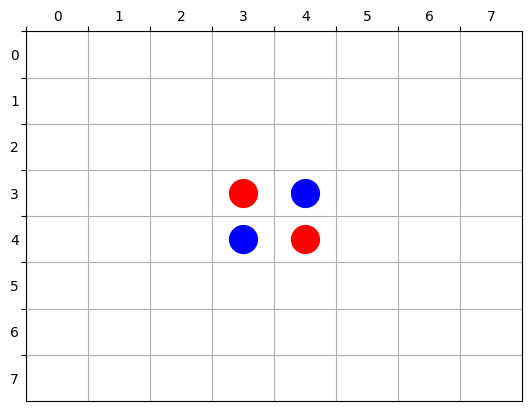

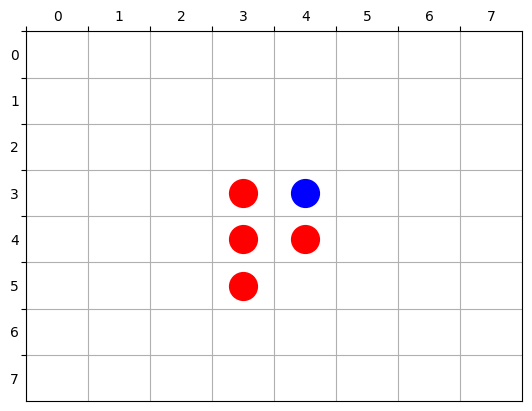

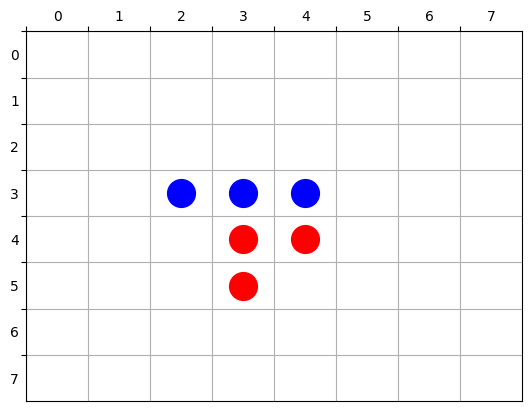

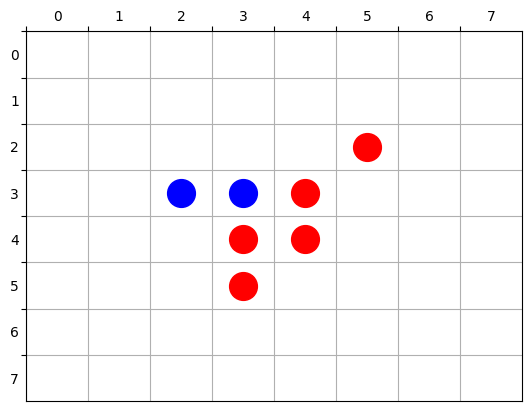

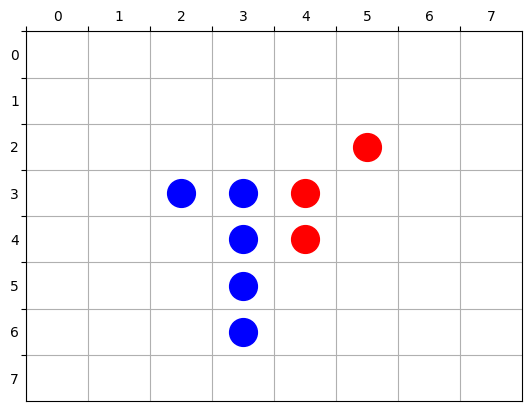

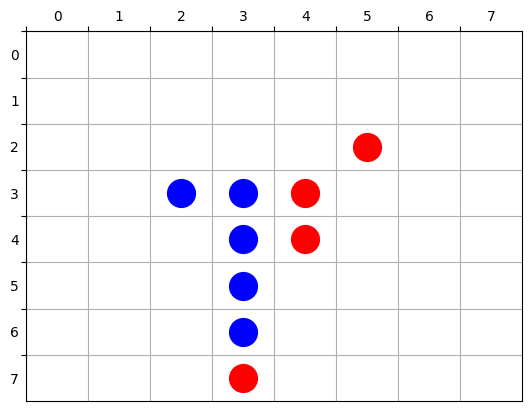

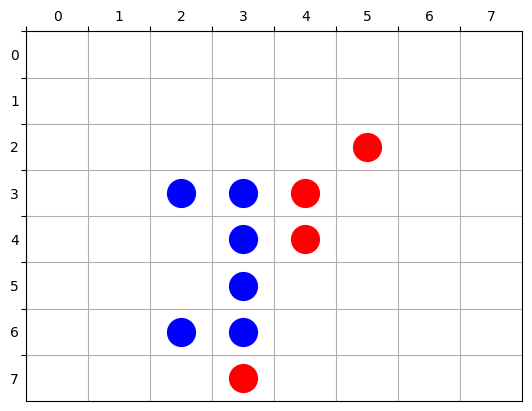

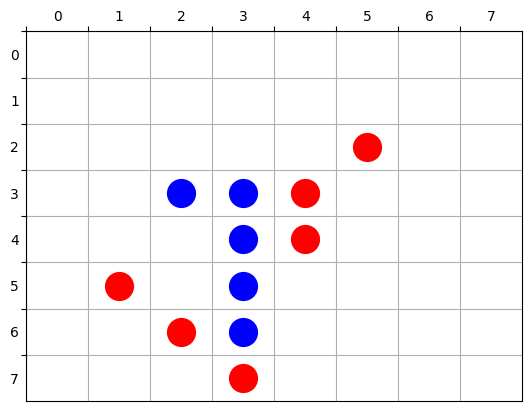

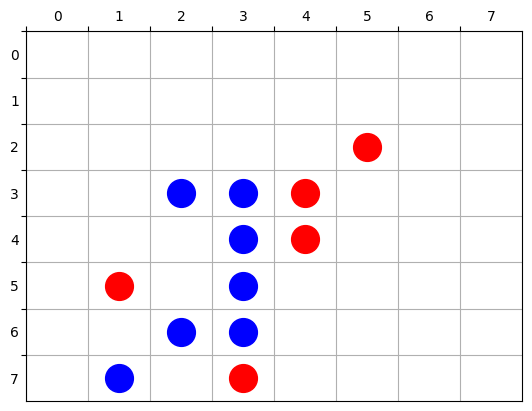

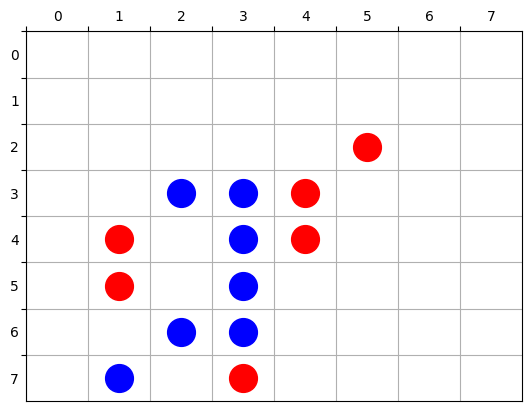

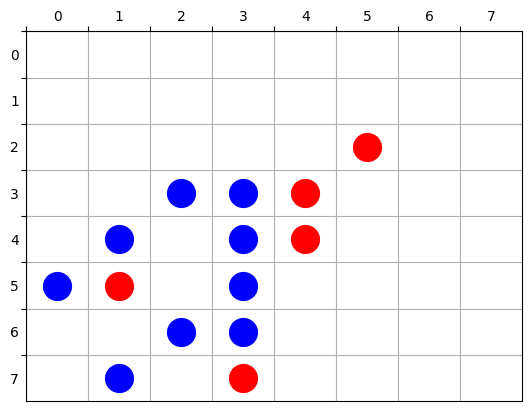

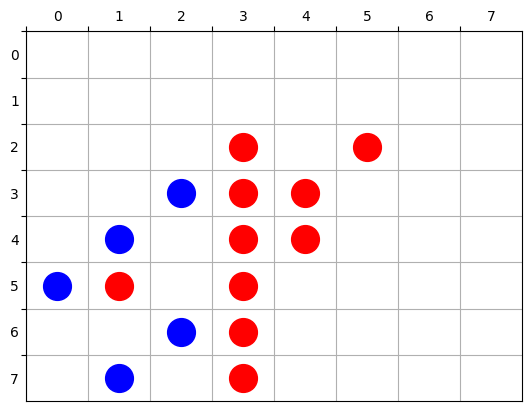

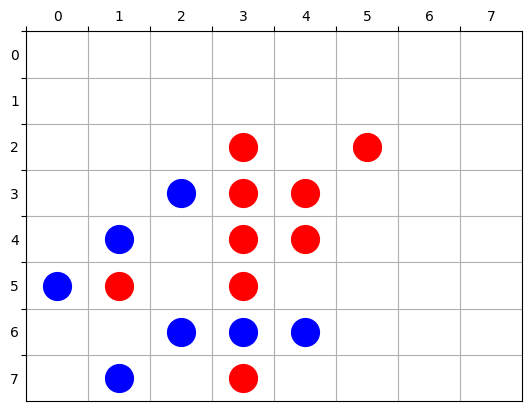

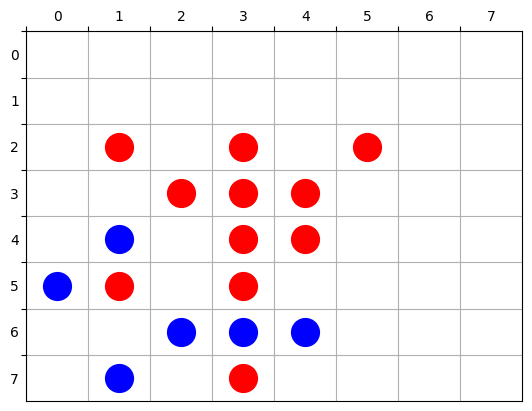

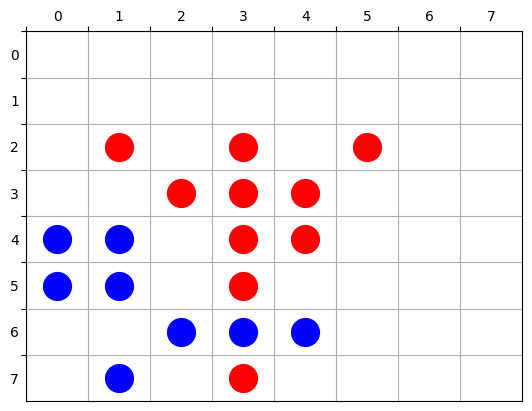

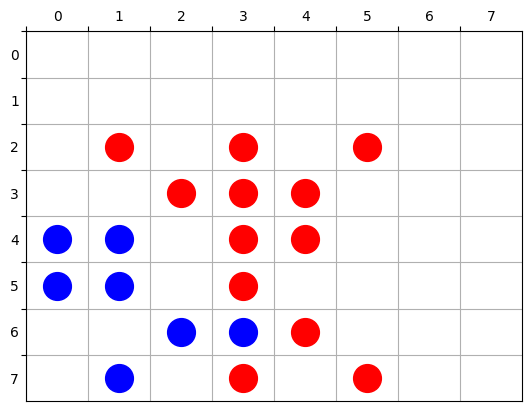

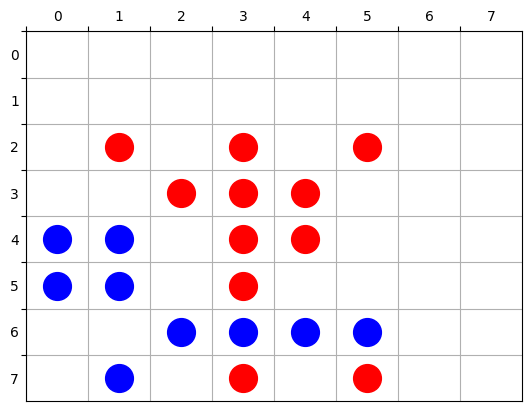

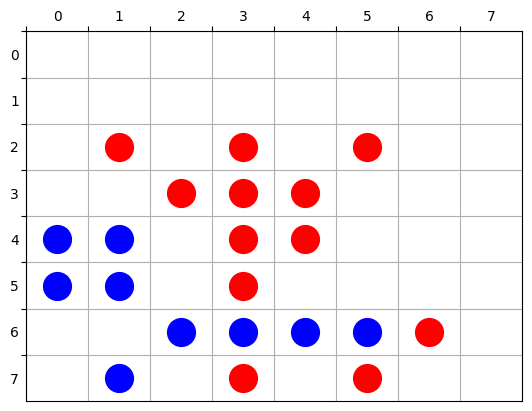

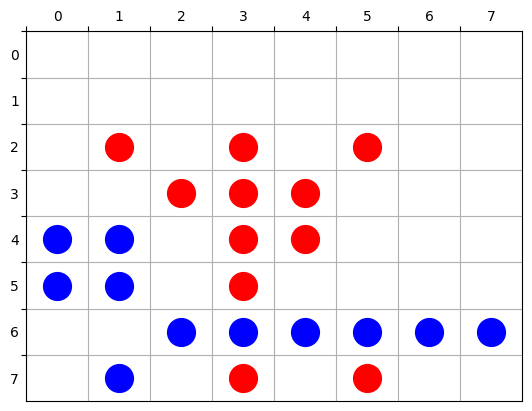

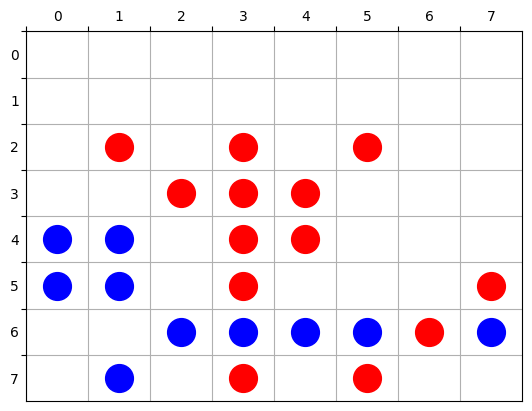

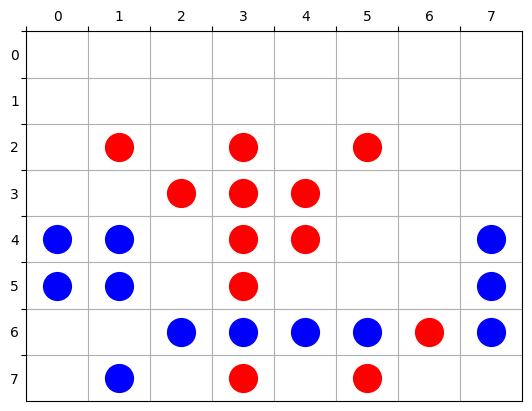

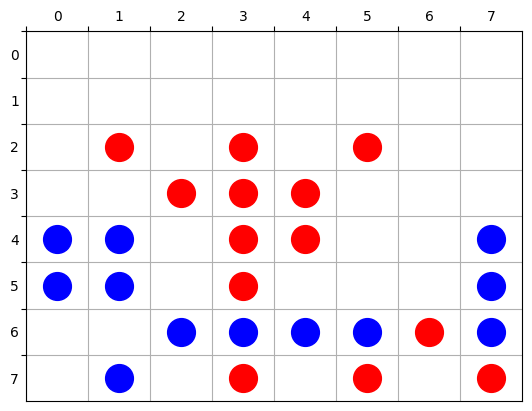

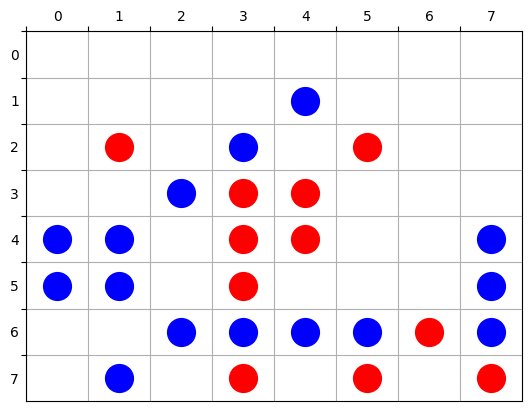

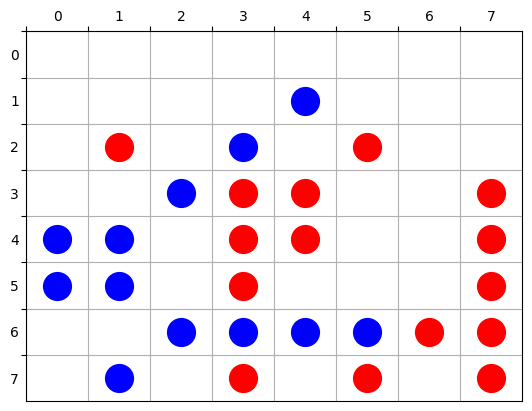

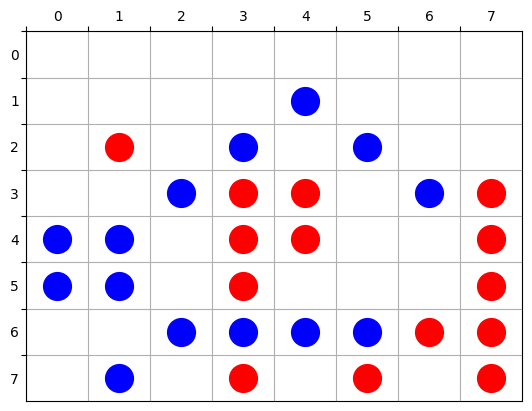

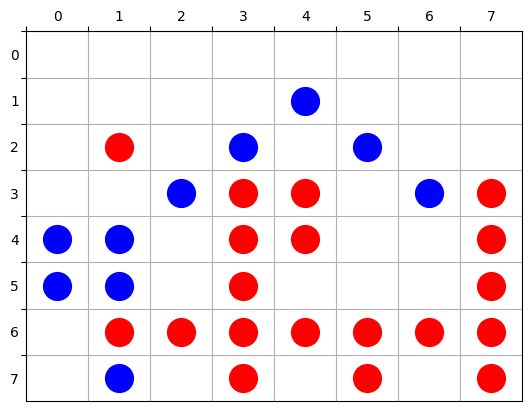

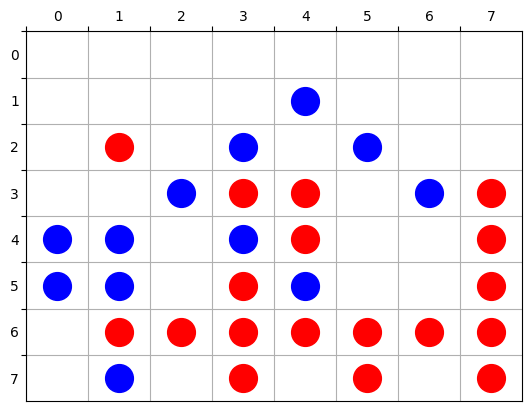

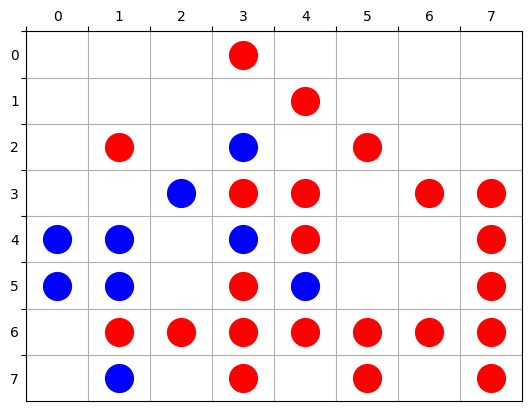

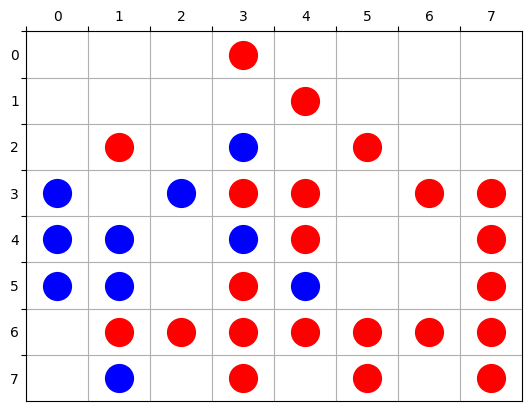

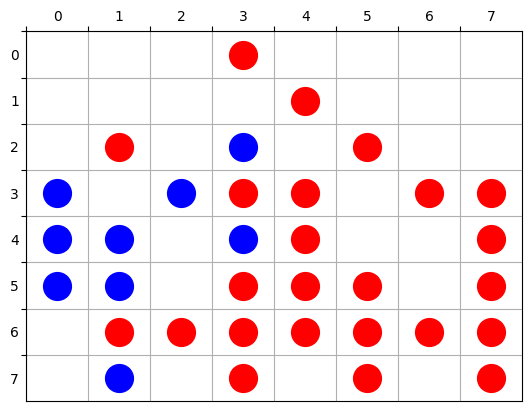

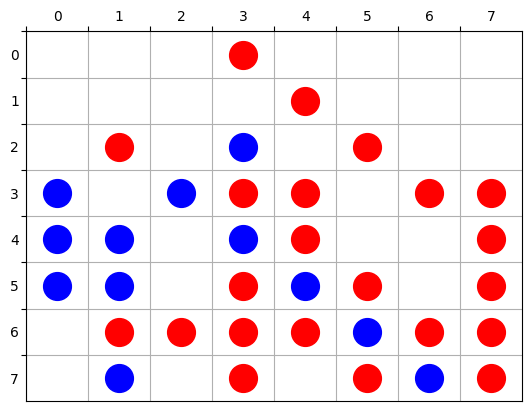

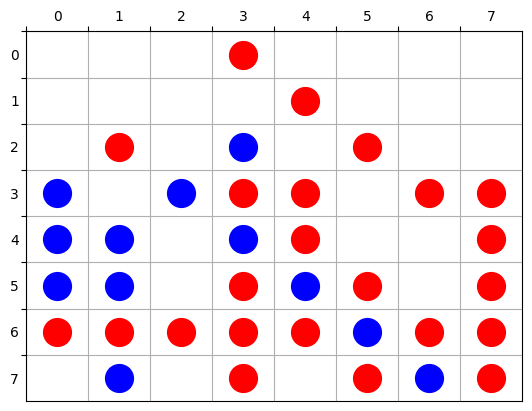

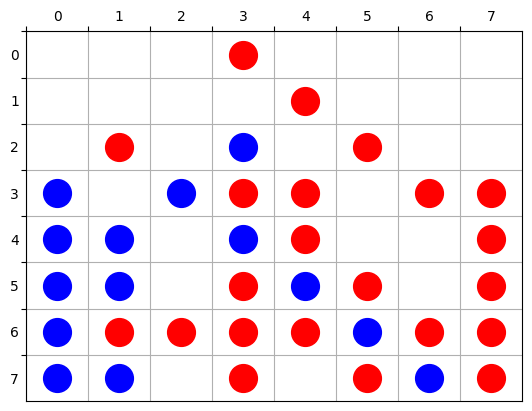

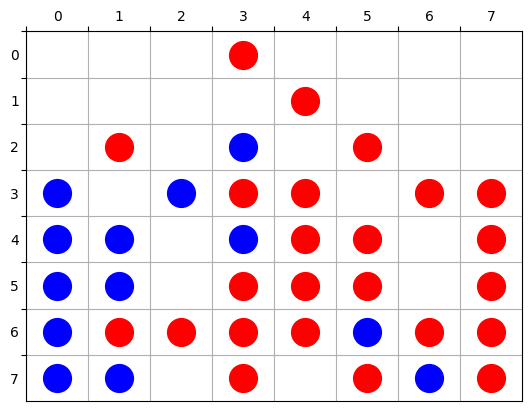

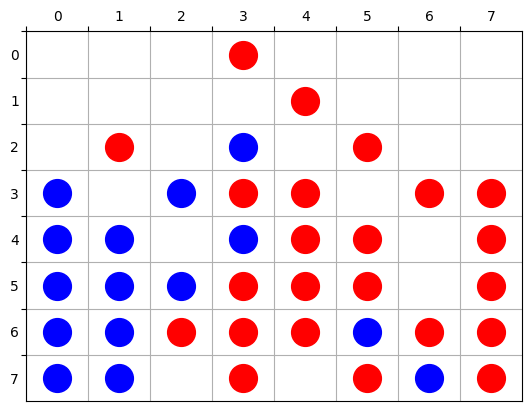

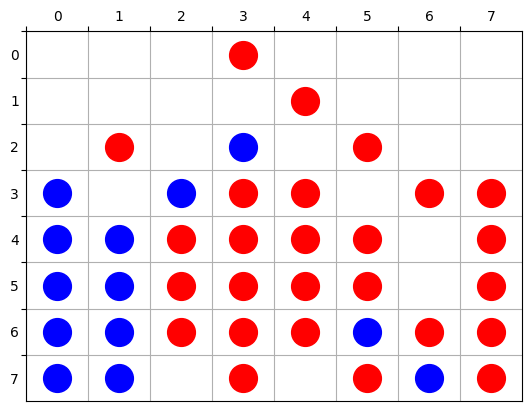

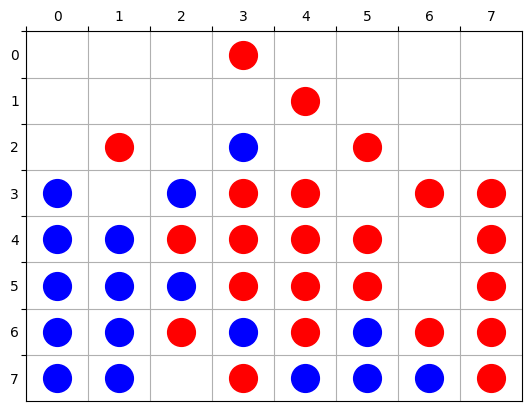

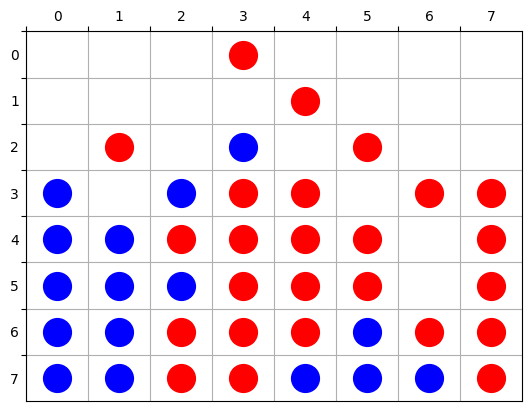

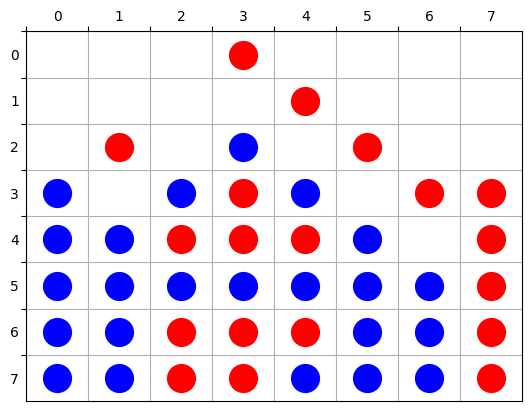

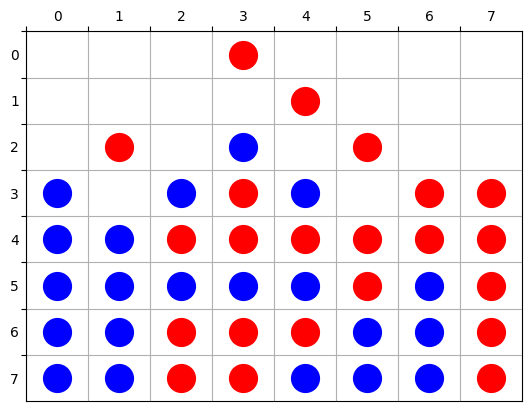

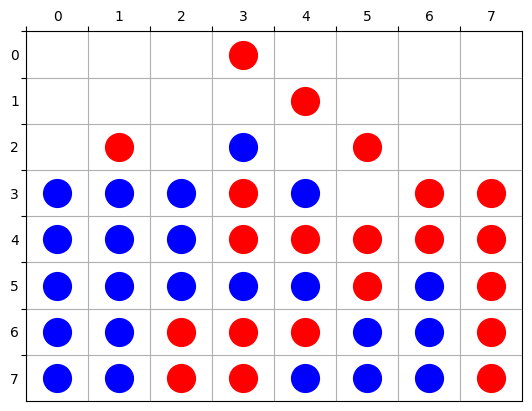

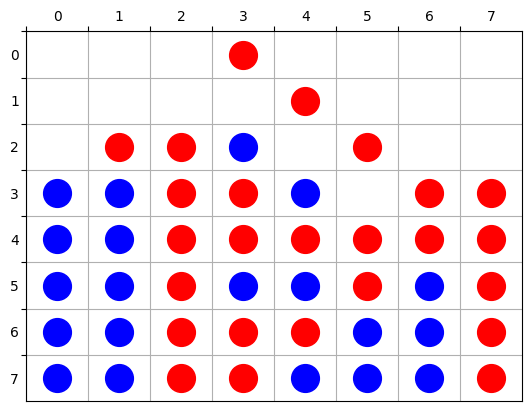

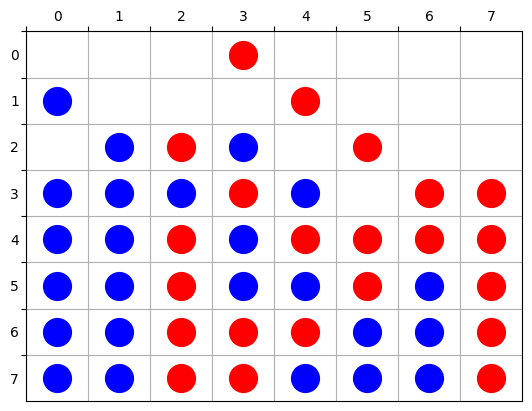

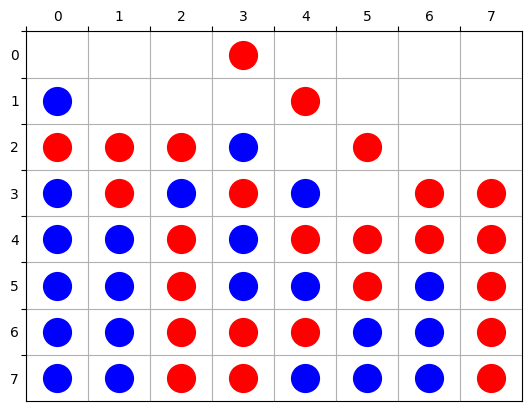

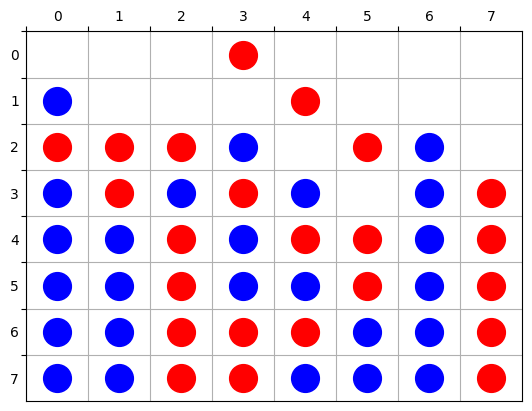

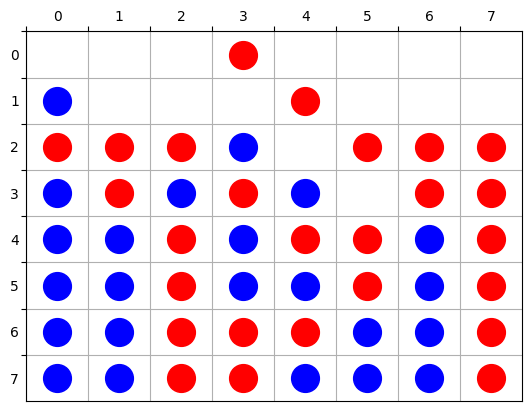

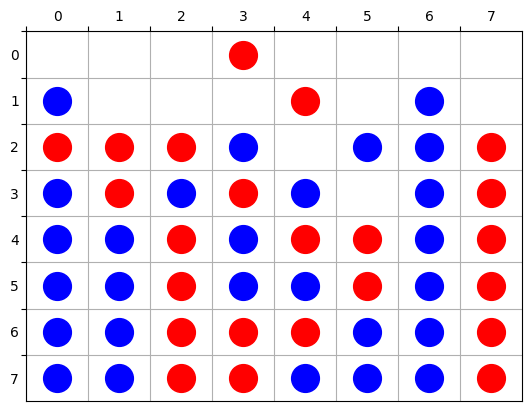

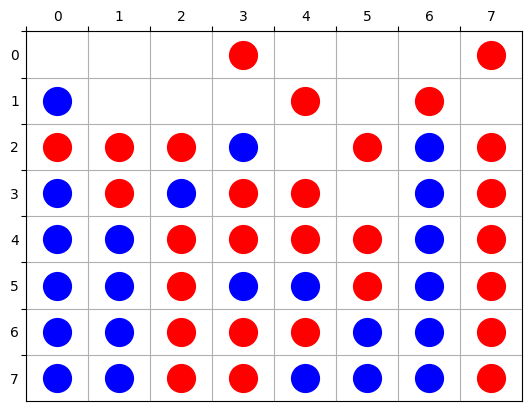

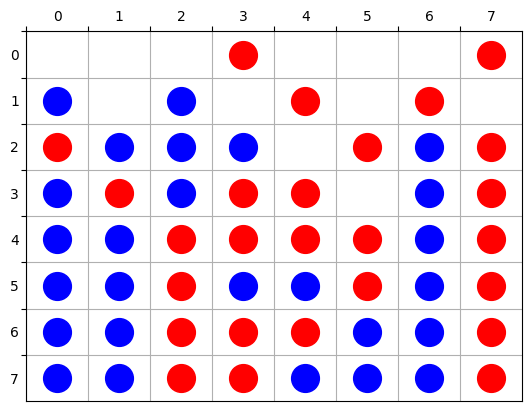

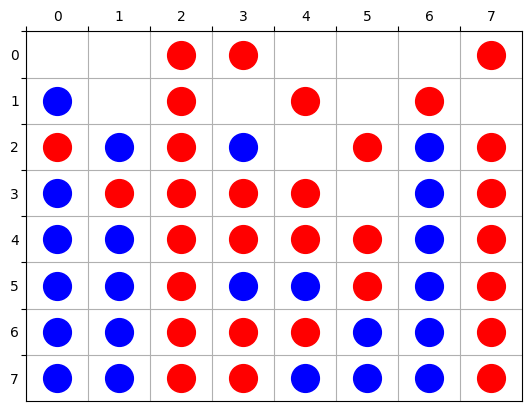

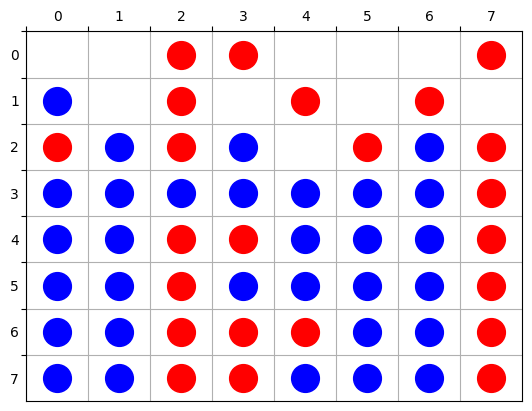

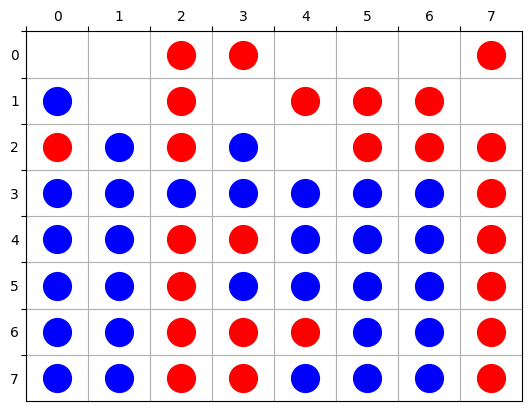

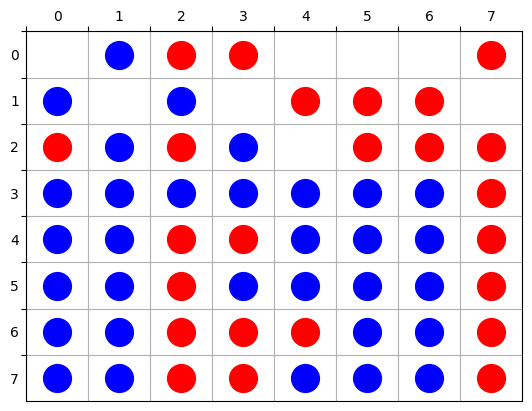

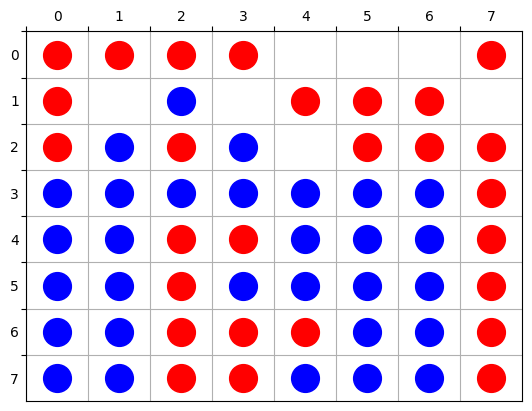

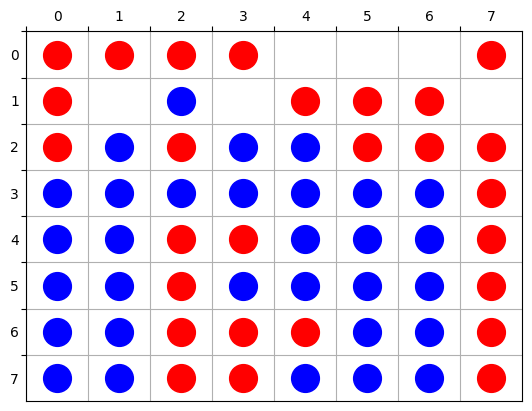

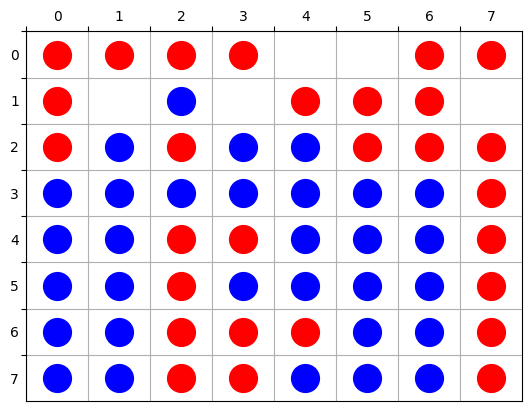

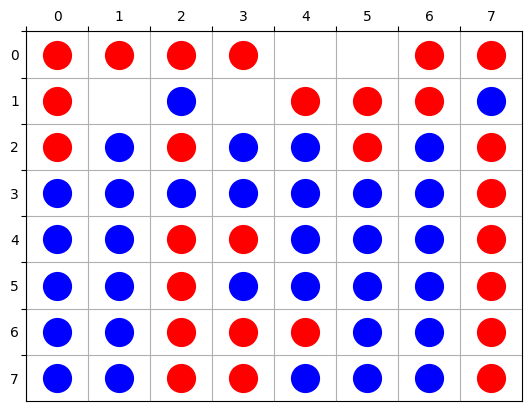

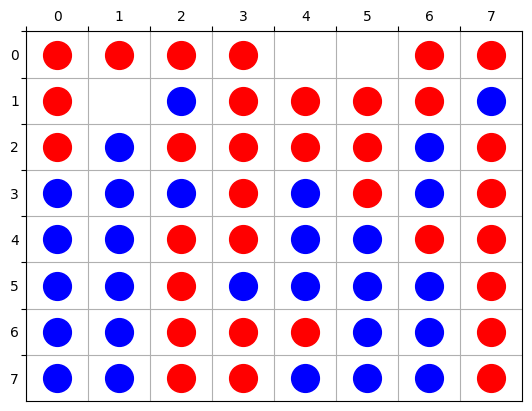

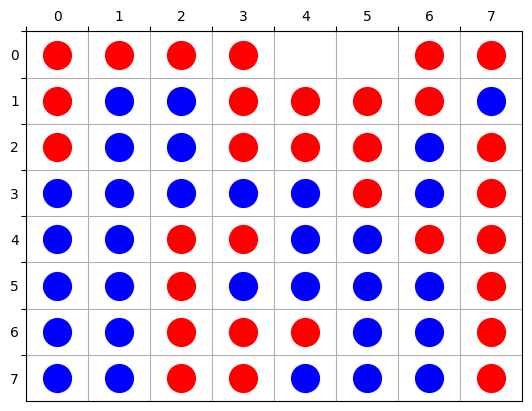

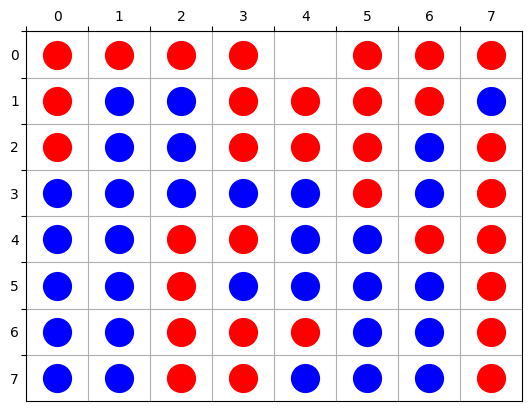

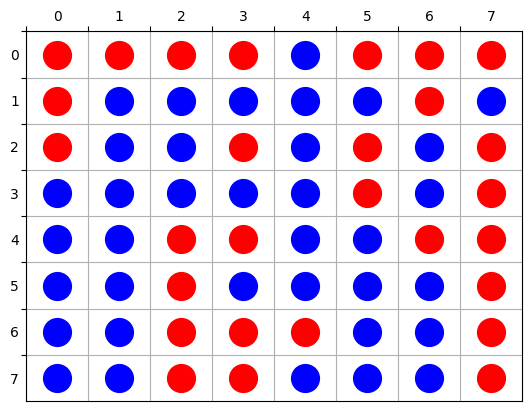

In [22]:
c = 1
A = np.zeros((8,8), int)
A[3,3] = 1
A[3,4] = -1
A[4,3] = -1
A[4,4] = 1
tracerPlateau(A)

for _ in range(60):
    _, (c, A) = minmax_gen(transition_othello, score_othello, (c, A), c, 3)
    plt.figure()
    tracerPlateau(A)
    plt.show()